---
> # **Estudo Quantitativo** - Estratégia *Ronaldinho*
---

A estratégia é bem simples:

* Timeframe de 5 ou 10 minutos;
* Esperar o candle de 9:55 ou 9:50 fechar e terá que ser um candle de baixa;
* Comprar na abertura do candle das 10 horas com stop de 300 pontos;
* Saída da operação no fechamento do candle de 10 horas ou com alvo fixo.

_OBS.: vi essa estratégia no canal do **Viana Trader** no vídeo: [OPERANDO COM RONALDINHO NO MINI ÍNDICE + MINI DÓLAR](https://www.youtube.com/watch?v=-cUPbGoWzH0)_

# 1 - Bibliotecas

In [1]:
# Análise e manipulação de dados gerais
import numpy as np
import pandas as pd

# Dados séries temporais
from datetime import datetime, timedelta
import pytz

# Dados OHLCV
from mt5linux import MetaTrader5
from datetime import datetime

# connecto to the server
mt5 = MetaTrader5()
mt5.execute('import datetime')

# Bibliotecas gráficas
import mplfinance as mpf
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# 2 - Obtenção dos dados

In [2]:
mt5.initialize()

True

In [3]:
ticker = 'WIN$N'

In [4]:
timezone = pytz.timezone("America/Sao_Paulo")
data_inicio = datetime.now() - timedelta(days=300)
data_fim = datetime.now()

In [5]:
dados_ohlcv = mt5.copy_rates_range(ticker, mt5.TIMEFRAME_M1, data_inicio, data_fim)
dados_ohlcv = pd.DataFrame(dados_ohlcv)
dados_ohlcv['ticker'] = str(ticker)
dados_ohlcv['timeframe'] = '01_min'
dados_ohlcv.index = pd.to_datetime(dados_ohlcv['time'], unit='s')
dados_ohlcv = dados_ohlcv.drop('time', axis=1)
dados_ohlcv

,open,high,low,close,tick_volume,spread,real_volume,ticker,timeframe
time,,,,,,,,,
2022-06-03 14:49:00,111585.0,111610.0,111555.0,111605.0,4883,5,17297,WIN$N,01_min
2022-06-03 14:50:00,111610.0,111615.0,111560.0,111560.0,3994,5,11348,WIN$N,01_min
2022-06-03 14:51:00,111560.0,111590.0,111545.0,111570.0,5238,5,16963,WIN$N,01_min
2022-06-03 14:52:00,111570.0,111580.0,111550.0,111565.0,2985,5,8886,WIN$N,01_min
2022-06-03 14:53:00,111560.0,111590.0,111515.0,111555.0,5699,5,18588,WIN$N,01_min
...,...,...,...,...,...,...,...,...,...
2023-03-30 11:44:00,103830.0,103915.0,103760.0,103865.0,4392,0,52805,WIN$N,01_min
2023-03-30 11:45:00,103870.0,103940.0,103840.0,103890.0,3849,0,42929,WIN$N,01_min
2023-03-30 11:46:00,103890.0,103915.0,103725.0,103785.0,4210,0,50846,WIN$N,01_min


## 2.1 - Fazendo o resample dos dados

In [6]:
df = dados_ohlcv.resample('10T').agg({'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last', 'real_volume':'sum', 'ticker': 'first'})
df.tail()

,open,high,low,close,real_volume,ticker
time,,,,,,
2023-03-30 11:00:00,104070.0,104125.0,103065.0,103640.0,834883,WIN$N
2023-03-30 11:10:00,103640.0,103905.0,103030.0,103140.0,779437,WIN$N
2023-03-30 11:20:00,103140.0,103665.0,103100.0,103655.0,407377,WIN$N
2023-03-30 11:30:00,103650.0,103780.0,103240.0,103765.0,458757,WIN$N
2023-03-30 11:40:00,103765.0,103940.0,103590.0,103780.0,367678,WIN$N


## 2.2 - Definindo a direção do candle

In [7]:
df.loc[df['close'] > df['open'], 'direction'] = 1
df.loc[df['close'] < df['open'], 'direction'] = -1
df['direction'].fillna(0)
df.dropna(inplace=True)

# 3. Filtrando as entradas

In [8]:
def entrada_compra(hora_minuto, direcao):
    hora_minuto_anterior = hora_minuto.shift(1)
    direcao_anterior = direcao.shift(1)
    
    regra_1 = (hora_minuto_anterior == '09:50')
    regra_2 = (direcao_anterior == -1.0)
    
    return (regra_1 & regra_2)

In [9]:
# Definindo o stop da operação
alvo = 150
stop = 300

In [10]:
data = df.copy()
data['return'] = (data.close / data.open - 1)*100
data['points'] = data.close - data.open

data['return_stop'] = np.where(data.low <= data.open - stop, ((data.open - stop)/data.open - 1)*100, data['return'])
data['points_stop'] = np.where(data.low <= data.open - stop, -stop, data['points'])

data['hour'] = data.index.strftime('%H:%M')
data['compra'] = entrada_compra(data.hour, data.direction)
data.tail()

,open,high,low,close,real_volume,ticker,direction,return,points,return_stop,points_stop,hour,compra
time,,,,,,,,,,,,,
2023-03-30 11:00:00,104070.0,104125.0,103065.0,103640.0,834883,WIN$N,-1.0,-0.413183,-430.0,-0.288268,-300.0,11:00,False
2023-03-30 11:10:00,103640.0,103905.0,103030.0,103140.0,779437,WIN$N,-1.0,-0.482439,-500.0,-0.289464,-300.0,11:10,False
2023-03-30 11:20:00,103140.0,103665.0,103100.0,103655.0,407377,WIN$N,1.0,0.499321,515.0,0.499321,515.0,11:20,False
2023-03-30 11:30:00,103650.0,103780.0,103240.0,103765.0,458757,WIN$N,1.0,0.110950,115.0,-0.289436,-300.0,11:30,False
2023-03-30 11:40:00,103765.0,103940.0,103590.0,103780.0,367678,WIN$N,1.0,0.014456,15.0,0.014456,15.0,11:40,False


### Filtrando as entradas de compra

In [11]:
df_compra = data[data.compra == True]
df_compra

,open,high,low,close,real_volume,ticker,direction,return,points,return_stop,points_stop,hour,compra
time,,,,,,,,,,,,,
2022-06-06 10:00:00,112115.0,112195.0,112020.0,112085.0,343657,WIN$N,-1.0,-0.026758,-30.0,-0.026758,-30.0,10:00,True
2022-06-07 10:00:00,109815.0,110060.0,109620.0,109995.0,641573,WIN$N,1.0,0.163912,180.0,0.163912,180.0,10:00,True
2022-06-08 10:00:00,109325.0,109415.0,109175.0,109390.0,412765,WIN$N,1.0,0.059456,65.0,0.059456,65.0,10:00,True
2022-06-10 10:00:00,106190.0,106310.0,105830.0,105885.0,486134,WIN$N,-1.0,-0.287221,-305.0,-0.282512,-300.0,10:00,True
2022-06-13 10:00:00,103540.0,104045.0,103490.0,103935.0,503544,WIN$N,1.0,0.381495,395.0,0.381495,395.0,10:00,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-20 10:00:00,102735.0,102965.0,102615.0,102925.0,538324,WIN$N,1.0,0.184942,190.0,0.184942,190.0,10:00,True
2023-03-21 10:00:00,101845.0,102030.0,101730.0,101985.0,452079,WIN$N,1.0,0.137464,140.0,0.137464,140.0,10:00,True
2023-03-22 10:00:00,101585.0,101640.0,101400.0,101490.0,366568,WIN$N,-1.0,-0.093518,-95.0,-0.093518,-95.0,10:00,True


### Conferindo o ponto de entrada no gráfico

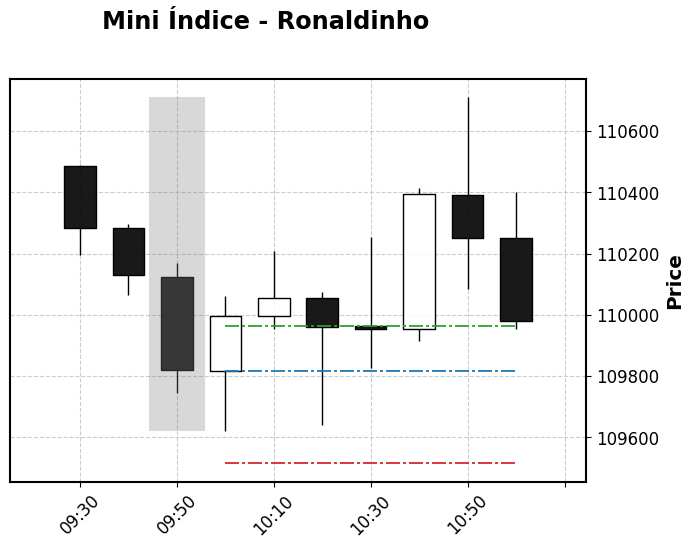

In [12]:
n_index = 1
inicio = df_compra.iloc[n_index].name - timedelta(minutes=30)
fim = df_compra.iloc[n_index].name + timedelta(minutes=60)

candle_index = 3

dfpl = df.loc[inicio:fim]

candle_signal = dfpl.index[candle_index-1].strftime('%Y-%m-%d %H:%M:%S')
candle_entry = dfpl.index[candle_index].strftime('%Y-%m-%d %H:%M:%S')
candle_end = dfpl.index[-1].strftime('%Y-%m-%d %H:%M:%S')

ponto_entrada = dfpl['open'].loc[candle_entry]
ponto_stop = dfpl['open'].loc[candle_entry] - stop
ponto_take = dfpl['open'].loc[candle_entry] + alvo

lines = [[(candle_entry,ponto_stop),(candle_end, ponto_stop)],
         [(candle_entry,ponto_entrada),(candle_end, ponto_entrada)],
         [(candle_entry,ponto_take),(candle_end, ponto_take)]]

alines = dict(alines=lines, linestyle='-.', colors=['tab:red', 'tab:blue', 'tab:green'], alpha=0.9, linewidths=1.5)
vlines=dict(vlines=candle_signal,linewidths=40,alpha=0.3, colors='tab:gray')
mpf.plot(dfpl, title='Mini Índice - Ronaldinho', type='candle', style='classic', vlines=vlines, alines=alines)

## 4. Gerando o resultado acumulado da estratégia

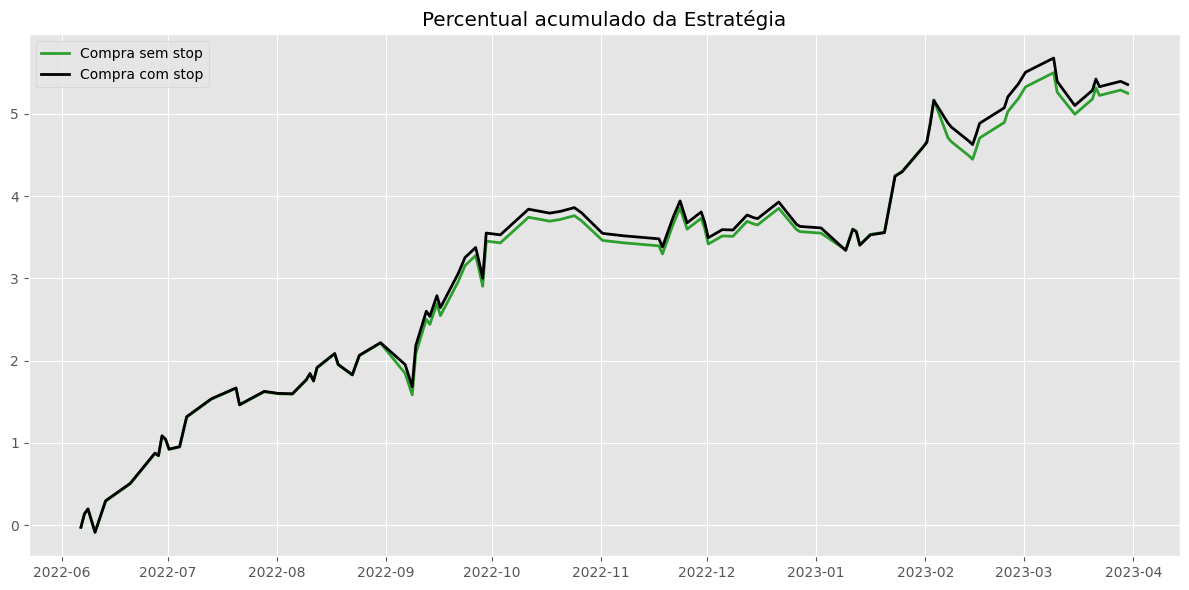

In [13]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(12,6))
plt.title('Percentual acumulado da Estratégia')
plt.plot(df_compra['return'].cumsum(), color='tab:green', label='Compra sem stop')
plt.plot(df_compra['return_stop'].cumsum(), color='black', label='Compra com stop')
plt.legend()
plt.tight_layout()
plt.show();

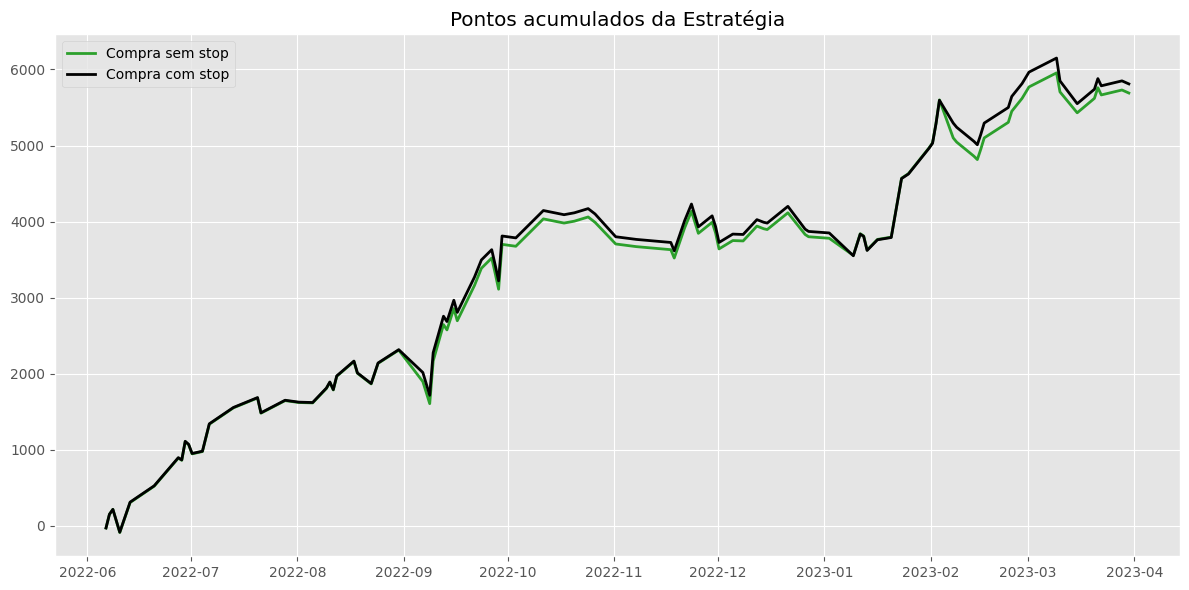

In [14]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(12,6))
plt.title('Pontos acumulados da Estratégia')
plt.plot(df_compra['points'].cumsum(), color='tab:green', label='Compra sem stop')
plt.plot(df_compra['points_stop'].cumsum(), color='black', label='Compra com stop')
plt.legend()
plt.tight_layout()
plt.show();